In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from mppi import Parsers as P, Utilities as U
from mppi.Utilities import Constants as C
from mppi.Models import TwoLevelSystems as TLS
from mppi.Models import GaussianPulse as G
import matplotlib.pyplot as plt
import os

# TLS description of spin polarization in GaAs

In this notebook we use the TLS model to describe the time evolution of the spin polarization in GaAS.

Here we assume the a first optical pump has excited the electrons in the first two conduction bands
and we describe the dynamics in the conduction sector using the TLS. The interaction with a second
THz field is described entirely within this sector.

## TLS analysis for a single k point

The parameters common in the yambo and in the TLS analysis are

In [3]:
fwhm_THz = 20 # ps 
THz_int = 1.1767  #kW/cm2
T_delay = 1 # ps
de_ccp = 0.9445 # meV
energy = de_ccp # energy of the THz pulse
NETime = 80 # ps
ntimes = 16003 # as in the rt simulations (for the green function)
numk = 48 # the single k point is replicated due to fixsymm procedure

h_red = C.Planck_reduced_ev_ps*1e3 # hbar in meV*ps
omega = energy/h_red # angular frequency of the pulse

We use the TLS to reproduce the results written in

In [4]:
ref_rundir = 'SPIN_ECHO/RT_singlek_high-freq/FixSymm/'
ref_outpath = 'SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi'

In [5]:
ref_results = P.YamboParser.from_path(ref_rundir,ref_outpath)

Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/o-echo_THz_pi.polarization
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/o-echo_THz_pi.spin_magnetization
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/o-echo_THz_pi.current
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/o-echo_THz_pi.external_field
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/o-echo_THz_pi.orbt_magnetization
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/o-echo_THz_pi.carriers
Parse file : SPIN_ECHO/RT_singlek_high-freq/FixSymm/SAVE/ns.db1
Parse file : SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/ndb.dipoles
Parse file : SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/ndb.RT_G_PAR


In [6]:
#ref_results.get_info()

In [7]:
# We build the reference quantities to compare with the TLS results

ref_time = 1e-3*ref_results.data['external_field']['time']
ref_Ex = ref_results.data['external_field']['Ex_Re']
ref_Pz = ref_results.data['spin_magnetization']['Mc_z']

green = ref_results.RTGreen
dm = green.buildDensityMatrix(first_band=2)
u_ref = P.buildBlochVectors(dm)

We define the array with the $x$ component of the transition dipoles

In [8]:
x_dipole = ref_results.dipoles.r_dipole(0,first_band=2)
x_dipole[0]

array([[ 0.         +0.j        , 15.27632319+22.94874198j],
       [15.27632319-22.94874198j,  0.         +0.j        ]])

Note that the $x_{01}$ component that is the equivalent of the $\mu_{12}$ dipole (with opposite sign!)  defined in theory of the TLS.

We compute the field amplitude and the Rabi coupling associated to a given field intensity.
To this scope we select the first k point and set the intensity of the field to have the $\pi$ condition on this point.

In [9]:
k_ref = 0
mu12_ref = -x_dipole[k_ref,0,1]
theta = np.pi
pars = TLS.pulseParametersFromTheta(mu12_ref,np.pi,fwhm=fwhm_THz,THz_pulse=True)
pars

time unit: ps
the width parameter of the pulse is 8.493218002880191 ps
Rabi coupling (ps^-1): (-0.08177049377812073-0.12283911124034695j)
Rabi coupling (module) (ps^-1): 0.14756646266356058
field amplitude (V/m): 66579.79073343561
field intensity (kW/cm^2) : 1.1766689276495992


{'Omega0': (-0.08177049377812073-0.12283911124034695j),
 'Omega0_abs': 0.14756646266356058,
 'field_amplitude': 66579.79073343561,
 'intensity': 1.1766689276495992}

In [10]:
amplitude = pars['field_amplitude']
Omega0_abs = pars['Omega0_abs']
intensity = pars['intensity']

We build a pulse with the aim to reproduce exactly the one created by yambo.

In [11]:
time = np.linspace(0,NETime,ntimes) # in ps

In [12]:
pulse = G.gaussianPulse(time,energy=de_ccp,amplitude=amplitude,fwhm=fwhm_THz,THz_pulse=True,t_start=T_delay,envelope_only=False)

time unit: ps - energy unit: meV
period of the oscillations 4.3786846979696366 ps
width of the pulse 8.493218002880191 ps
fwhm of the pulse 20 ps


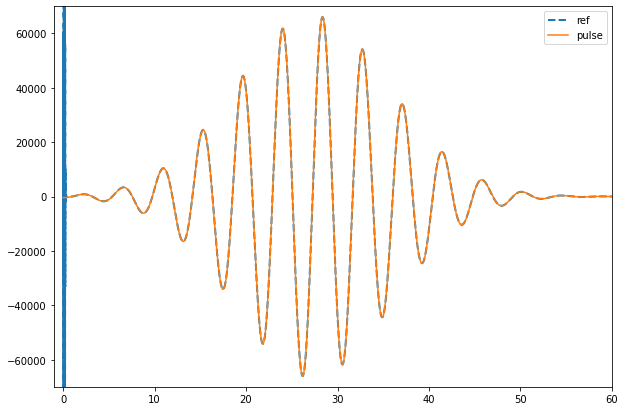

In [13]:
plt.figure(figsize=(10,7))
plt.plot(ref_time,ref_Ex,label='ref',linestyle='--',linewidth=2)
plt.plot(time,pulse,label='pulse')
plt.ylim(-70e3,70e3)
plt.xlim(-1,60)
plt.legend()

### Solution of the Bloch equations

We use a reference calculation to extract the _initial time_ bloch vectors. We choose t=1 ps as the time value at
which the initial condition is set. In this way the THz pulse start at t=0 in the TLS analysis

In [14]:
ind0 = np.where(time<=1)[0][-1] 
print('t0 =',time[ind0])
u_ref0 = u_ref[:,ind0,:]
trace_ref = np.trace(dm[ind0],axis1=1,axis2=2).real

t0 = 0.9998750156230471


In [20]:
uprime = np.zeros([3,ntimes,numk])
delta = energy - de_ccp # in meV
delta_psm1 = delta/h_red # in ps^-1

for k in range(numk):
    uprime0 = u_ref0[:,k]
    mu12 = -x_dipole[k,0,1]
    pars = TLS.pulseParametersFromIntensity(mu12,intensity,fwhm=fwhm_THz,THz_pulse=True,verbose=False)
    Omega = lambda t : G.gaussianPulse(t,energy=energy,amplitude=pars['Omega0_abs'],fwhm=fwhm_THz,envelope_only=True,verbose=False)
    uprime[:,:,k] = TLS.solveBlochEq(uprime0,time,Omega,mu12=mu12,delta=delta_psm1)

We plot the component of the $x$ vector in the rotating frame

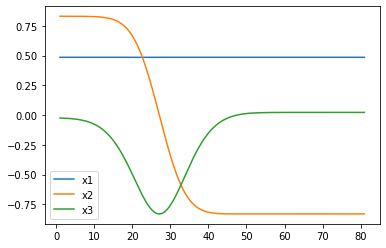

In [25]:
k = 0
mu12 = -x_dipole[k,0,1]
x = TLS.convertToXbasis(uprime[:,:,k],mu12=mu12)
plt.plot(1+time,x[0],label='x1')
plt.plot(1+time,x[1],label='x2')
plt.plot(1+time,x[2],label='x3')
plt.legend()

we observe that the $x$ component remains constant while the other two change sign, as
expected in a $\pi$ pulse.

We rotate the Bloch vector in the original frame

In [16]:
u = np.zeros([3,ntimes,numk])
for k in range(numk):
    u[:,:,k] = TLS.convertToRotatingFrame(omega,time,uprime[:,:,k],invert=True)

time unit: ps
the width parameter of the pulse is 8.493218002880191 ps
Rabi coupling (ps^-1): (0.08177049377812073+0.12283911124034695j)
Rabi coupling (module) (ps^-1): 0.14756646266356058
field amplitude (V/m): 66579.79073343561
pulse area : 3.141592653589793


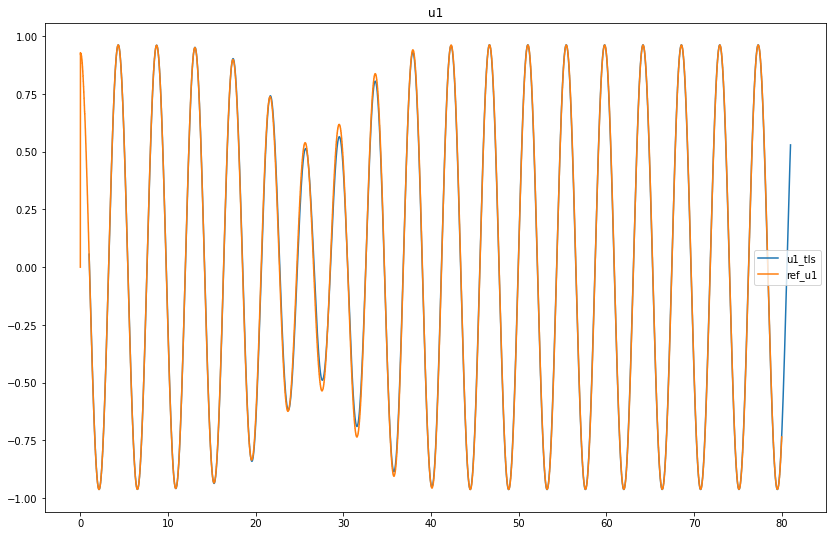

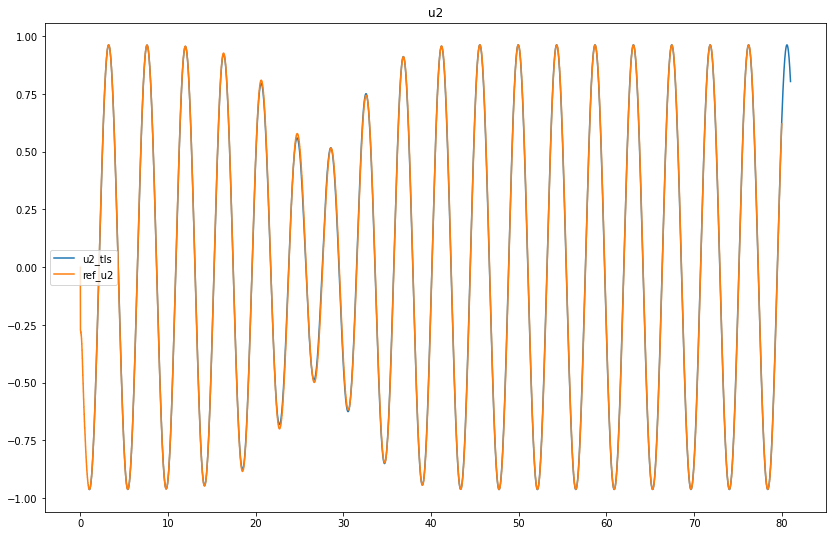

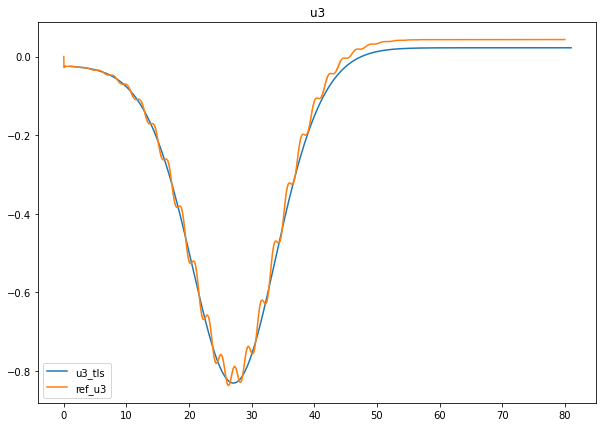

In [17]:
k = 0

pars_k = TLS.pulseParametersFromIntensity(x_dipole[k,0,1],intensity,fwhm=fwhm_THz,THz_pulse=True)

plt.figure(figsize=(14,9))
plt.title('u1')
plt.plot(1+time,u[0,:,k],label='u1_tls')
plt.plot(time,u_ref[0,:,k],label='ref_u1')
plt.legend()
plt.show()

plt.figure(figsize=(14,9))
plt.title('u2')
plt.plot(1+time,u[1,:,k],label='u2_tls')
plt.plot(time,u_ref[1,:,k],label='ref_u2')
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.title('u3')
plt.plot(1+time,u[2,:,k],label='u3_tls')
plt.plot(time,u_ref[2,:,k],label='ref_u3')
plt.legend()
plt.show()

We can compute the spin polarization obtained in the TLS description and compare it with the reference result.
 
Assuming that the Sz operator has diagonal elements with opposite values $(Sz_{00}=-Sz_{11})$
we can express the expectation value of $S_z$ as
$$
S_z(k,t) = \mathrm{Tr}_{cc'}(\rho(k,t)\left(
u_{3}(k,t)Sz_{00}(k)+u_1(k,t)Re(Sz_{10}(k))+u_2(k,t)Im(Sz_{10}(k)\right) 
$$
Then, the degree of spin polarization is defined as
$$
P_z(t) = \frac{\mathrm{Tr}_{k} \left(S_z(k,t)\right)}{\mathrm{Tr}_{cc'k}(\rho(k,t)}
$$

In [19]:
spin_dipole = ref_results.dipoles.spin_dipole(2,first_band=2)
spin_dipole.shape

(48, 2, 2)

In [20]:
Rsz10 = spin_dipole[:,1,0].real
Isz10 = spin_dipole[:,1,0].imag
sz00 = spin_dipole[:,0,0].real
Sz_k_tls = (u[0]*Rsz10+u[1]*Isz10+u[2]*sz00)*trace_ref
Sz_tls = np.mean(Sz_k_tls,axis=1)
carriers = np.mean(trace_ref,axis=0)
Pz_tls = np.true_divide(Sz_tls,carriers,where=carriers != 0)

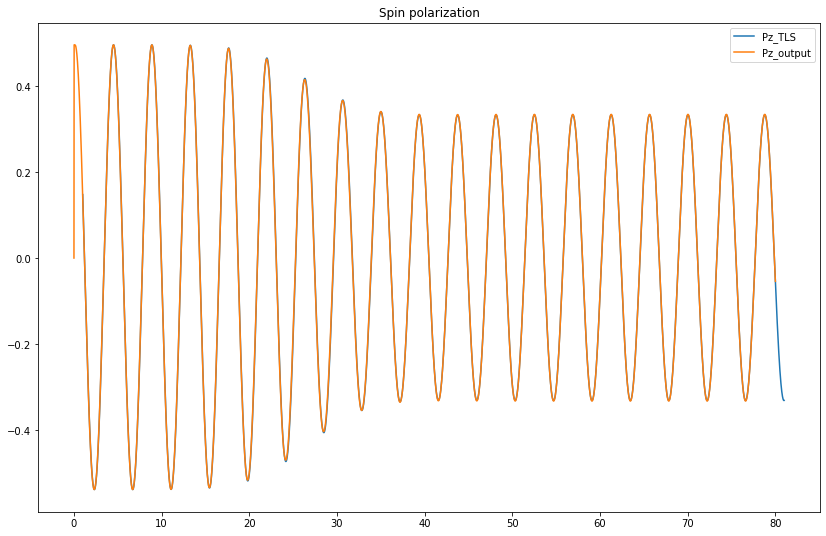

In [21]:
plt.figure(figsize=(14,9))
plt.plot(1+time,Pz_tls,label='Pz_TLS')
plt.plot(ref_time,ref_Pz,label='Pz_output')
plt.title('Spin polarization')
plt.legend()

## TLS analysis for a single k point (with a THz pulse detuned with respect to the gap)

The parameters common in the yambo and in the TLS analysis are

In [64]:
fwhm_THz = 20 # ps 
THz_int = 1.1767  #kW/cm2
T_delay = 1 # ps
de_ccp = 0.9445 # meV
energy = 0.8 # energy of the THz pulse in meV
NETime = 80 # ps
ntimes = 16003 # as in the rt simulations (for the green function)
numk = 48

h_red = C.Planck_reduced_ev_ps*1e3 # hbar in meV*ps
omega = energy/h_red # angular frequency of the pulse

We use the TLS to reproduce the results written in

In [65]:
ref_rundir = 'SPIN_ECHO/RT_singlek_high-freq/FixSymm/'
ref_outpath = 'SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi_detuned/'

In [66]:
ref_results = P.YamboParser.from_path(ref_rundir,ref_outpath)

Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi_detuned/o-echo_THz_pi_detuned.spin_magnetization
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi_detuned/o-echo_THz_pi_detuned.polarization
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi_detuned/o-echo_THz_pi_detuned.carriers
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi_detuned/o-echo_THz_pi_detuned.current
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi_detuned/o-echo_THz_pi_detuned.orbt_magnetization
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi_detuned/o-echo_THz_pi_detuned.external_field
Parse file : SPIN_ECHO/RT_singlek_high-freq/FixSymm/SAVE/ns.db1
Parse file : SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi_detuned/ndb.dipoles
Parse file : SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi_detuned/ndb.RT_G_PAR


In [67]:
#ref_results.get_info()

In [68]:
# We build the reference quantities to compare with the TLS results

ref_time = 1e-3*ref_results.data['external_field']['time']
ref_Ex = ref_results.data['external_field']['Ex_Re']
ref_Pz = ref_results.data['spin_magnetization']['Mc_z']

green = ref_results.RTGreen
dm = green.buildDensityMatrix(first_band=2)
u_ref = P.buildBlochVectors(dm)

We define the array with the $x$ component of the transition dipoles

In [69]:
x_dipole = ref_results.dipoles.r_dipole(0,first_band=2)
x_dipole[0]

array([[ 0.         +0.j        , 15.27632319+22.94874198j],
       [15.27632319-22.94874198j,  0.         +0.j        ]])

Note that the $x_{01}$ component that is the equivalent of the $\mu_{12}$ dipole (with opposite sign!)  defined in theory of the TLS.

We compute the field amplitude and the Rabi coupling associated to a given field intensity.
To this scope we select the first k point and set the intensity of the field to have the $\pi$ condition on this point.

In [70]:
k_ref = 0
mu12_ref = -x_dipole[k_ref,0,1]
theta = np.pi
pars = TLS.pulseParametersFromTheta(mu12_ref,np.pi,fwhm=fwhm_THz,THz_pulse=True)
pars

time unit: ps
the width parameter of the pulse is 8.493218002880191 ps
Rabi coupling (ps^-1): (-0.08177049377812073-0.12283911124034695j)
Rabi coupling (module) (ps^-1): 0.14756646266356058
field amplitude (V/m): 66579.79073343561
field intensity (kW/cm^2) : 1.1766689276495992


{'Omega0': (-0.08177049377812073-0.12283911124034695j),
 'Omega0_abs': 0.14756646266356058,
 'field_amplitude': 66579.79073343561,
 'intensity': 1.1766689276495992}

In [71]:
amplitude = pars['field_amplitude']
Omega0_abs = pars['Omega0_abs']
intensity = pars['intensity']

We build a pulse with the aim to reproduce exactly the one created by yambo.

In [72]:
time = np.linspace(0,NETime,ntimes) # in ps

In [73]:
pulse = G.gaussianPulse(time,energy=energy,amplitude=amplitude,fwhm=fwhm_THz,THz_pulse=True,t_start=T_delay,envelope_only=False)

time unit: ps - energy unit: meV
period of the oscillations 5.169584621540402 ps
width of the pulse 8.493218002880191 ps
fwhm of the pulse 20 ps


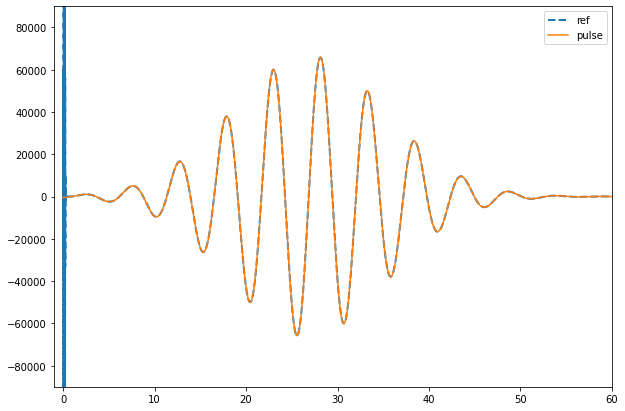

In [74]:
plt.figure(figsize=(10,7))
plt.plot(ref_time,ref_Ex,label='ref',linestyle='--',linewidth=2)
plt.plot(time,pulse,label='pulse')
plt.ylim(-90e3,90e3)
plt.xlim(-1,60)
plt.legend()

### Solution of the Bloch equations

We use a reference calculation to extract the _initial time_ bloch vectors. We choose t=1 ps as the time value at
which the initial condition is set. In this way the THz pulse start at t=0 in the TLS analysis

In [75]:
ind0 = np.where(time<=1)[0][-1] 
print('t0 =',time[ind0])
u_ref0 = u_ref[:,ind0,:]
trace_ref = np.trace(dm[ind0],axis1=1,axis2=2).real

t0 = 0.9998750156230471


In [78]:
uprime = np.zeros([3,ntimes,numk])
delta = energy - de_ccp # in meV
delta_psm1 = delta/h_red # in ps^-1

for k in range(numk):
    uprime0 = u_ref0[:,k]
    mu12 = -x_dipole[k,0,1]
    pars = TLS.pulseParametersFromIntensity(mu12,intensity,fwhm=fwhm_THz,THz_pulse=True,verbose=False)
    Omega = lambda t : G.gaussianPulse(t,energy=energy,amplitude=pars['Omega0_abs'],fwhm=fwhm_THz,envelope_only=True,verbose=False)
    uprime[:,:,k] = TLS.solveBlochEq(uprime0,time,Omega,mu12=mu12,delta=delta_psm1)

We plot the component of the $x$ vector in the rotating frame

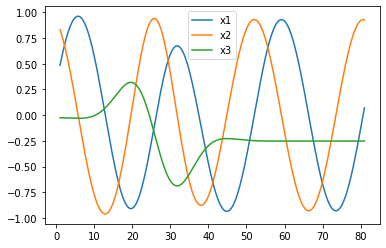

In [79]:
k = 0
mu12 = -x_dipole[k,0,1]
x = TLS.convertToXbasis(uprime[:,:,k],mu12=mu12)
plt.plot(1+time,x[0],label='x1')
plt.plot(1+time,x[1],label='x2')
plt.plot(1+time,x[2],label='x3')
plt.legend()

we observe that in this case, due to the detuning, thecomponents of the $x$ vector undergo to a precession 
of angular frequency $\delta$ during the action of the pulse. For this reason at the end of the pulse the Bloch
vector has __not__ changed sign.

We rotate the Bloch vector in the original frame

In [51]:
u = np.zeros([3,ntimes,numk])
for k in range(numk):
    u[:,:,k] = TLS.convertToRotatingFrame(omega,time,uprime[:,:,k],invert=True)

time unit: ps
the width parameter of the pulse is 8.493218002880191 ps
Rabi coupling (ps^-1): (0.08177049377812073+0.12283911124034695j)
Rabi coupling (module) (ps^-1): 0.14756646266356058
field amplitude (V/m): 66579.79073343561
pulse area : 3.141592653589793


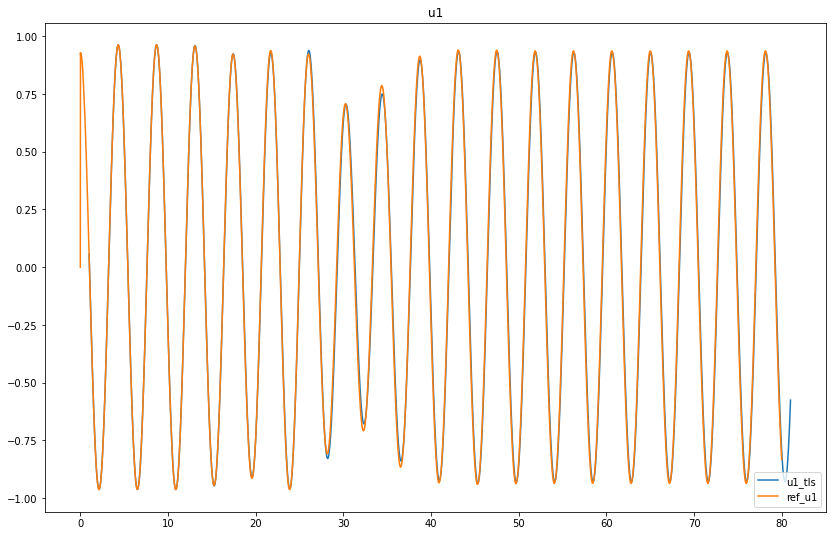

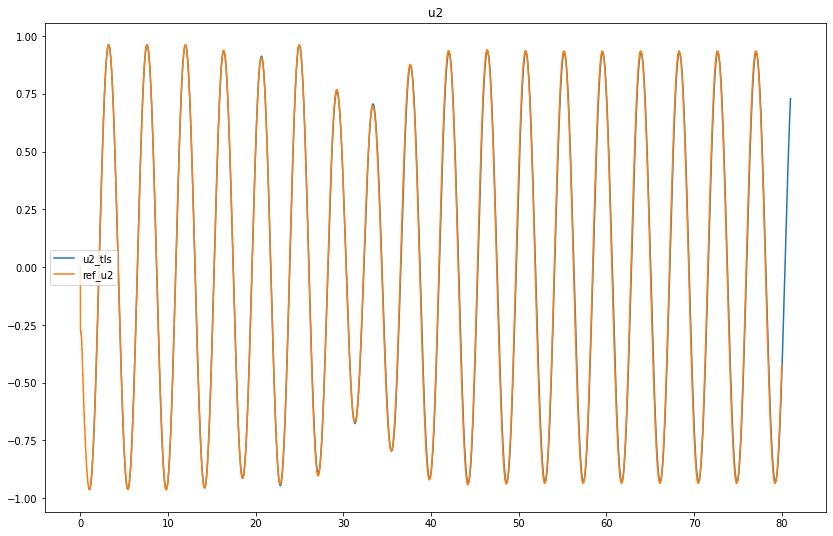

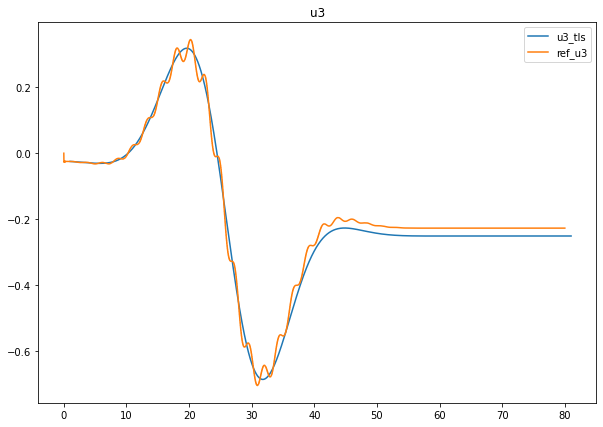

In [52]:
k = 0

pars_k = TLS.pulseParametersFromIntensity(x_dipole[k,0,1],intensity,fwhm=fwhm_THz,THz_pulse=True)

plt.figure(figsize=(14,9))
plt.title('u1')
plt.plot(1+time,u[0,:,k],label='u1_tls')
plt.plot(time,u_ref[0,:,k],label='ref_u1')
plt.legend()
plt.show()

plt.figure(figsize=(14,9))
plt.title('u2')
plt.plot(1+time,u[1,:,k],label='u2_tls')
plt.plot(time,u_ref[1,:,k],label='ref_u2')
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.title('u3')
plt.plot(1+time,u[2,:,k],label='u3_tls')
plt.plot(time,u_ref[2,:,k],label='ref_u3')
plt.legend()
plt.show()

We can compute the spin polarization obtained in the TLS description and compare it with the reference result.
 
Assuming that the Sz operator has diagonal elements with opposite values $(Sz_{00}=-Sz_{11})$
we can express the expectation value of $S_z$ as
$$
S_z(k,t) = \mathrm{Tr}_{cc'}(\rho(k,t)\left(
u_{3}(k,t)Sz_{00}(k)+u_1(k,t)Re(Sz_{10}(k))+u_2(k,t)Im(Sz_{10}(k)\right) 
$$
Then, the degree of spin polarization is defined as
$$
P_z(t) = \frac{\mathrm{Tr}_{k} \left(S_z(k,t)\right)}{\mathrm{Tr}_{cc'k}(\rho(k,t)}
$$

In [53]:
spin_dipole = ref_results.dipoles.spin_dipole(2,first_band=2)
spin_dipole.shape

(48, 2, 2)

In [54]:
Rsz10 = spin_dipole[:,1,0].real
Isz10 = spin_dipole[:,1,0].imag
sz00 = spin_dipole[:,0,0].real
Sz_k_tls = (u[0]*Rsz10+u[1]*Isz10+u[2]*sz00)*trace_ref
Sz_tls = np.mean(Sz_k_tls,axis=1)
carriers = np.mean(trace_ref,axis=0)
Pz_tls = np.true_divide(Sz_tls,carriers,where=carriers != 0)

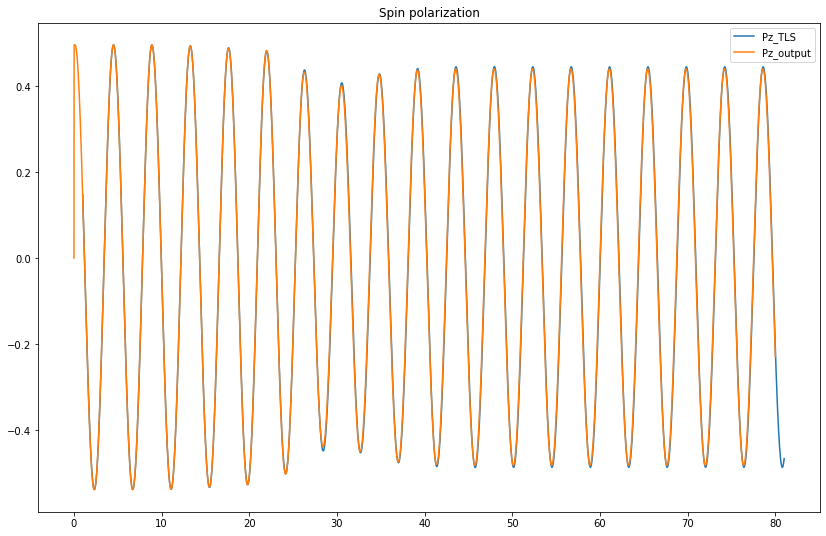

In [55]:
plt.figure(figsize=(14,9))
plt.plot(1+time,Pz_tls,label='Pz_TLS')
plt.plot(ref_time,ref_Pz,label='Pz_output')
plt.title('Spin polarization')
plt.legend()

## TLS analysis for an ensemble of 100 k points

### Solution of the Bloch equations without the THz pulse

In [56]:
energy = 1 # energy of the Thz pump in meV (it is not relevant here since the THz pulse is absent)
h_red = C.Planck_reduced_ev_ps*1e3 # hbar in meV*ps
omega = energy/h_red # angular frequency of the pulse

We use the TLS to reproduce the results written in

In [57]:
ref_rundir = 'SPIN_ECHO/RT_k100_random/FixSymm/'
ref_outpath = 'SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory'

In [58]:
ref_results = P.YamboParser.from_path(ref_rundir,ref_outpath)

Parse file SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory/o-k100_random_boost_Ghistory.spin_magnetization
Parse file SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory/o-k100_random_boost_Ghistory.external_field
Parse file SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory/o-k100_random_boost_Ghistory.orbt_magnetization
Parse file SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory/o-k100_random_boost_Ghistory.polarization
Parse file SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory/o-k100_random_boost_Ghistory.carriers
Parse file SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory/o-k100_random_boost_Ghistory.current
Parse file : SPIN_ECHO/RT_k100_random/FixSymm/SAVE/ns.db1
Parse file : SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory/ndb.dipoles
Parse file : SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory/ndb.RT_G_PAR


In [59]:
#ref_results.get_info()

In [60]:
# We build the reference quantities to compare with the TLS results

time_output = 1e-3*ref_results.data['external_field']['time']
Pz_output = ref_results.data['spin_magnetization']['Mc_z']

dm = ref_results.RTGreen.buildDensityMatrix(first_band=4)
u_ref = P.buildBlochVectors(dm)

We define the array with the $x$ component of the transition dipoles

In [61]:
x_dipole = ref_results.dipoles.r_dipole(0,first_band=4)
x_dipole[1]

array([[ 0.         +0.j       , -6.81249622-26.6724818j],
       [-6.81249622+26.6724818j,  0.         +0.j       ]])

We define the array with the transition energies in function of k

In [62]:
de_ccp_k = 1e3*ref_results.dft.get_transitions(initial=[8,9],final=[8,9])[:,0]

We choose t=1 ps as the time value at which the initial condition is set.

In [72]:
comp,ntimes_ref,numk = u_ref.shape
ntimes_ref,numk

(403, 4753)

In [73]:
NETime_ref = 10 # the length of the yambo simulation in ps 
time_ref = np.linspace(0,NETime_ref,ntimes_ref) # in ps

We extract the _initial conditions_ of the TLS analysis from the RT density matrix. Note that, apart from the Bloch vector we also need
the values of the k dependent trace of the $\rho_{cc'}$

In [74]:
ind0 = np.where(time_ref<=1)[0][-1] 
print('t0 =',time_ref[ind0])
u_ref0 = u_ref[:,ind0,:]
trace_ref = np.trace(dm[ind0],axis1=1,axis2=2).real

t0 = 0.9950248756218906


In [75]:
NETime = 20 # length of the TLS analysis in ps
ntimes= 1000
time = np.linspace(0,NETime,ntimes)

In [76]:
uprime = np.zeros([3,ntimes,numk])
Omega = lambda t : 0

for k in range(numk):
    omega0= de_ccp_k[k]/h_red
    delta = omega - omega0
    uprime0 = u_ref0[:,k]
    mu12 = -x_dipole[k,0,1]
    uprime[:,:,k] = TLS.solveBlochEq(uprime0,time,Omega,mu12=mu12,delta=delta)

We rotate the Bloch vector in the original frame

In [77]:
u = np.zeros([3,ntimes,numk])
for k in range(numk):
    u[:,:,k] = TLS.convertToRotatingFrame(omega,time,uprime[:,:,k],invert=True)

We compare the TLS Bloch vector with the RT ones for a selected value of k

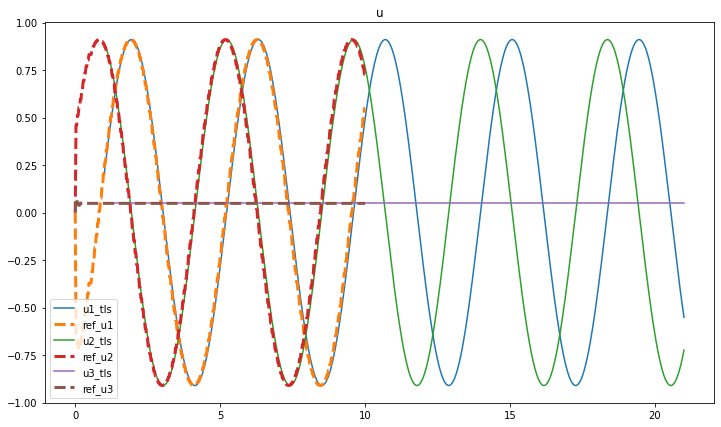

In [78]:
k = 1

plt.figure(figsize=(12,7))
plt.title('u')
plt.plot(1+time,u[0,:,k],label='u1_tls')
plt.plot(time_ref,u_ref[0,:,k],label='ref_u1',linestyle='--',linewidth=3)
plt.plot(1+time,u[1,:,k],label='u2_tls')
plt.plot(time_ref,u_ref[1,:,k],label='ref_u2',linestyle='--',linewidth=3)
plt.plot(1+time,u[2,:,k],label='u3_tls')
plt.plot(time_ref,u_ref[2,:,k],label='ref_u3',linestyle='--',linewidth=3)
plt.legend()

We can compute the spin polarization obtained in the TLS description and compare it with the reference result.
 
Assuming that the Sz operator has diagonal elements with opposite values $(Sz_{00}=-Sz_{11})$
we can express the expectation value of $S_z$ as
$$
S_z(k,t) = \mathrm{Tr}_{cc'}(\rho(k,t)\left(
u_{3}(k,t)Sz_{00}(k)+u_1(k,t)Re(Sz_{10}(k))+u_2(k,t)Im(Sz_{10}(k)\right) 
$$
Then, the degree of spin polarization is defined as
$$
P_z(t) = \frac{\mathrm{Tr}_{k} \left(S_z(k,t)\right)}{\mathrm{Tr}_{cc'k}(\rho(k,t)}
$$

In [82]:
spin_dipole = ref_results.dipoles.spin_dipole(2,first_band=4)
spin_dipole.shape

(4753, 2, 2)

In [83]:
Rsz10 = spin_dipole[:,1,0].real
Isz10 = spin_dipole[:,1,0].imag
sz00 = spin_dipole[:,0,0].real
Sz_k_tls = (u[0]*Rsz10+u[1]*Isz10+u[2]*sz00)*trace_ref
Sz_tls = np.mean(Sz_k_tls,axis=1)
carriers = np.mean(trace_ref,axis=0)
Pz_tls = np.true_divide(Sz_tls,carriers,where=carriers != 0)

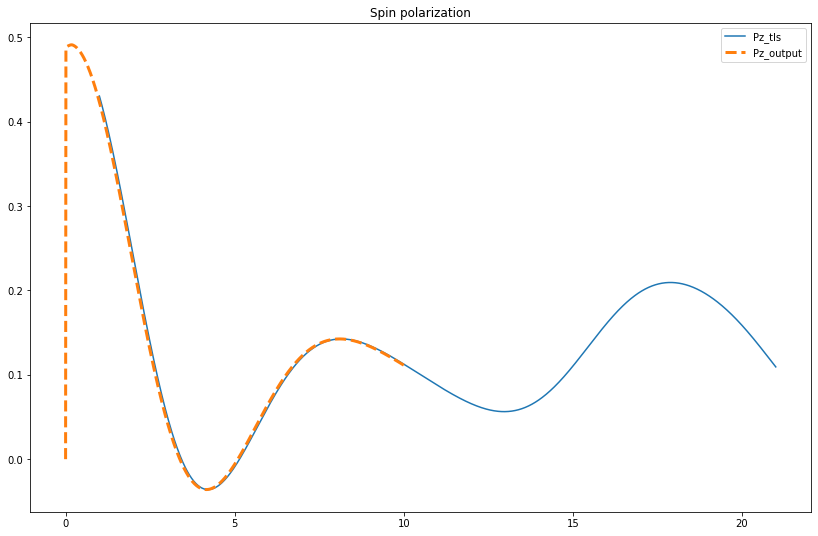

In [85]:
plt.figure(figsize=(14,9))
plt.plot(1+time,Pz_tls,label='Pz_tls')
plt.plot(time_output,Pz_output,label='Pz_output',linestyle='--',linewidth=3)
plt.title('Spin polarization')
plt.legend()

We observe that the TLS analysis is able to reproduce correctly the dynamics of the spin polarization

### Critical analysis on the possibilty of a spin echo mechanism

We try to undestand which are the conditions, concerning both the distribution of the transition energies of the 
conduction states and the features of the THz pulse, under which the echo mechanism can be enforced.

For each k point the initial condition evolves freely as
$$
x_k(t) = -y_k^0sin(\delta_k t) + x_k^0 cos(\delta_k t) \\
y_k(t) = y_k^0 cos(\delta_k t) + x_k^0 sin(\delta_k t) \\
z_k(t) = z_k^0
$$
The free evolution proceeds up to $t_1$ and, at this time, the THz pulse is activated. 
In order to build the echo signal the pulse is chosen to satisfy the $\pi$ condition
At this stage of the analysis we assume that the detuning $\delta_k$ can be neglected during the
action of the pump, this conditions can be expressed as
$$
\delta_kt_{p} \ll \pi 
$$
for all the $k$ points. Here $t_p$ is the length needed to obtain a pulse area equal to $\pi$ (for a gaussian pulse
an effective parameter can be defined). A the end of the pulse the Bloch vectors read
$$
x_k(t_1+t_p) = x_k(t_1) \\
y_k(t_1+t_p) = -y_k(t_1) \\
z_k(t_1+t_p) = - z_k(t_1)
$$
Then a further free evolution of length $t_1$ follows, at this time the Bloch vectors read
$$
x_k(2t_1+t_p) = y_k(t_1)sin(\delta_k t_1) + x_k(t_1) cos(\delta_k t_1) \\
y_k(2t_1+t_p) = -y_k(t_1) cos(\delta_k t_1) + x_k(t_1) sin(\delta_k t_1) \\
z_k(2t_1+t_p) = -z_k(t_1)
$$
and expressing these equations in terms of the initial conditions provide
$$
x_k(2t_1+t_p) = x_k^0 \\
y_k(2t_1+t_p) = -y_k^0 \\
z_k(2t_1+t_p) = -z_k^0
$$
check the sign of x!

### Solution of the Bloch equations with the THz pulse. Analysis of the echo mechanism

We use the TLS to discuss the possibility of a revival of the spin polarization using a properly chosen echo pulse.

We choose a reference yambo computation used to read the dipoles, the (k dependent) values of the energy gap of the conduction
states and the _initial conditions_ for the Bloch vector. The TLS analysis starts at t=1 ps.

In [3]:
ref_rundir = 'SPIN_ECHO/RT_k100_random/FixSymm/'
ref_outpath = 'SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory'

In [4]:
ref_results = P.YamboParser.from_path(ref_rundir,ref_outpath)

Parse file SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory/o-k100_random_boost_Ghistory.spin_magnetization
Parse file SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory/o-k100_random_boost_Ghistory.external_field
Parse file SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory/o-k100_random_boost_Ghistory.orbt_magnetization
Parse file SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory/o-k100_random_boost_Ghistory.polarization
Parse file SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory/o-k100_random_boost_Ghistory.carriers
Parse file SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory/o-k100_random_boost_Ghistory.current
Parse file : SPIN_ECHO/RT_k100_random/FixSymm/SAVE/ns.db1
Parse file : SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory/ndb.dipoles
Parse file : SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory/ndb.RT_G_PAR


In [5]:
#ref_results.get_info()

In [6]:
# We extract the relevant quantities from the yambo computation

de_ccp = 1e3*ref_results.dft.get_transitions(initial=[8,9],final=[8,9])[:,0] # in meV
dm = ref_results.RTGreen.buildDensityMatrix(first_band=4)
trace_cc = np.trace(dm,axis1=2,axis2=3) #trace in the conduction sector
u_ref = P.buildBlochVectors(dm)

x_dipole = ref_results.dipoles.r_dipole(0,first_band=4)
spin_dipole = ref_results.dipoles.spin_dipole(2,first_band=4)

We choose t=1 ps as the time value at which the initial condition is set.

In [7]:
comp,ntimes_ref,numk = u_ref.shape
ntimes_ref,numk

(403, 4753)

In [8]:
NETime_ref = 10 # the length of the yambo simulation in ps 
time_ref = np.linspace(0,NETime_ref,ntimes_ref) # in ps

We extract the _initial conditions_ of the TLS analysis from the RT density matrix. Note that, apart from the Bloch vector we also need
the values of the k dependent trace of the $\rho_{cc'}$

In [9]:
ind0 = np.where(time_ref<=1)[0][-1] 
print('t0 =',time_ref[ind0])
u_ref0 = u_ref[:,ind0,:]
trace_ref0 = trace_cc[ind0]

t0 = 0.9950248756218906


We indiviudate the k points that are relevant for the dynamics. 

We use the trace of the density matrix as the relevance criterion and we choose only the k points with 
the value of the trace greater than a given threshold.

In [10]:
trace_thr = 2e-3
k_activated = np.where(trace_ref0 > trace_thr)[0]
k_activated.shape

(3192,)

We compare the expectation values of the the degree of the spin polarization

In [11]:
carriers = np.mean(trace_cc,axis=1).real
carriers_activated = np.mean(trace_cc[:,k_activated],axis=1).real

In [12]:
Sz_ref = np.mean(np.trace(np.matmul(dm,spin_dipole),axis1=2,axis2=3),axis=1).real
Pz_ref = np.true_divide(Sz_ref,carriers.real,where=carriers.real!=0)

In [13]:
Sz_ref_activated = np.mean(np.trace(np.matmul(dm[:,k_activated,:,:],spin_dipole[k_activated,:,:]),axis1=2,axis2=3),axis=1).real
Pz_ref_activated = np.true_divide(Sz_ref_activated,carriers_activated.real,where=carriers_activated.real!=0)

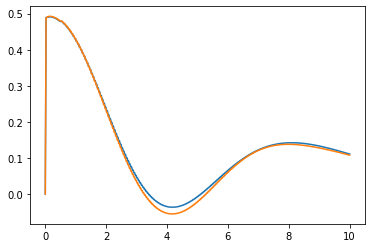

In [14]:
plt.plot(time_ref,Pz_ref)
plt.plot(time_ref,Pz_ref_activated)

We compute the jdos of the cc' transition restricted to this set of kpoints

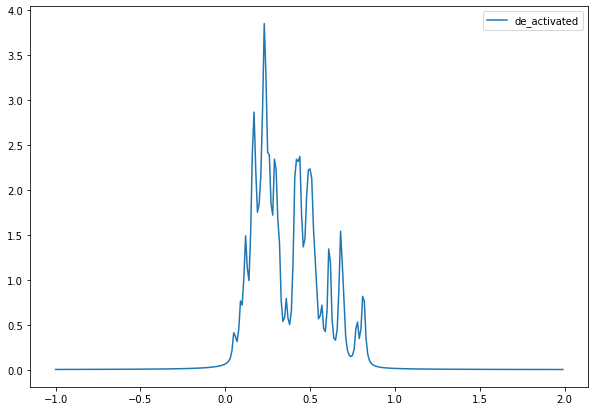

In [15]:
jdos = U.Dos()
plt.figure(figsize=(10,7))
jdos.append(de_ccp[k_activated],minVal=-1,maxVal=2,label='de_activated',eta=1e-2)
jdos.plot(plt)

Now we introduce the THz pulse and check for the condition $\delta_k t_p \ll \pi$
needed to realize the spin echo.

Looking at the jdos we want to define a THz pulse that is able to activate all the transition
associated to the k_activated ensemble.

In [16]:
NETime = 120 # ps. High value needed to compute the FT
ntimes = 2000
time = np.linspace(0,NETime,ntimes) # in ps

h_red = C.Planck_reduced_ev_ps*1e3 # hbar in meV*ps

time unit: fs - energy unit: eV
period of the oscillations 10.339169243080804 fs
width of the pulse 2.1233045007200477 fs
fwhm of the pulse 5 fs


(0.0, 30.0)

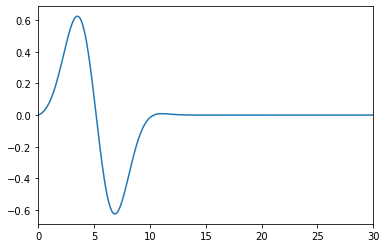

In [17]:
fwhm = 5 # ps 
energy = 0.4 # meV
omega = energy/h_red
pulse= G.gaussianPulse(time,energy=energy,amplitude=1,fwhm=fwhm)
plt.plot(time,pulse)
plt.xlim(0,30)

In [18]:
energies,pulse_ft = G.evalPulseFourierTransform(time,pulse,THz_pulse=True)

time unit: ps - energy unit: meV
energy resolution of the FT: 0.03444666551793332 meV
maximum energy: 34.412218852415386 meV
FWHM of the FT of the pulse: 0.6200399793227999 meV


(-1.0, 2.0)

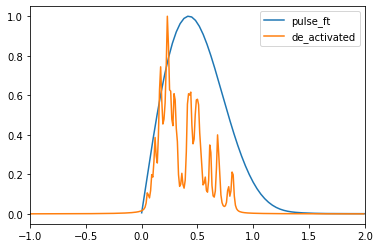

In [19]:
plt.plot(energies,pulse_ft/max(pulse_ft),label='pulse_ft')
jdos.plot(plt,rescale=True)
plt.xlim(-1,2)

We also define the delta array (defined on all the k points)

In [23]:
delta = omega-de_ccp/h_red
delta.shape

(4753,)

In [24]:
tp = 2*fwhm
delta_tp = delta[k_activated]*tp
delta_tp.max(),delta_tp.min()

(5.2716186261032565, -6.363204736030572)

Due to this spread for the values of delta_tp we __cannot__ expect that the
echo signal could emerge in this conditions.

As a test we select the k points for which delta_tp is below a given maximum values
and check for the emergence of a spin echo due to this subset

Check the value in the optical case!!!!

In [25]:
0.2*40/h_red

12.15413958212248

In [26]:
max_thr = 2

In [27]:
k_selected = k_activated[np.where(abs(delta_tp) < max_thr)[0]]
k_selected.shape

(1296,)

In [28]:
k_activated[0:100]

array([  2,   3,   4,   5,   6,   7,  10,  11,  12,  13,  14,  15,  16,
        17,  18,  19,  20,  21,  22,  24,  25,  27,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  44,  45,  47,
        48,  52,  54,  56,  61,  63,  64,  65,  68,  69,  74,  77,  78,
        79,  80,  82,  84,  86,  87,  88,  90,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132])

In [29]:
k_selected[0:100]

array([  3,   6,  14,  16,  19,  20,  27,  28,  31,  34,  37,  38,  41,
        44,  48,  52,  54,  61,  63,  65,  69,  77,  80,  82,  87,  93,
        97, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260,
       261, 262, 263, 264, 265, 266, 267, 268, 269])

In [30]:
k_selected.shape

(1296,)

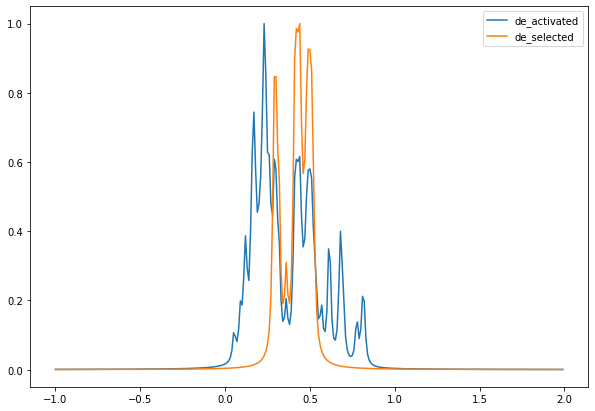

In [31]:
plt.figure(figsize=(10,7))
jdos.append(de_ccp[k_selected],minVal=-1,maxVal=2,label='de_selected',eta=1e-2)
jdos.plot(plt,rescale=True)

We analyze the spin echo on this subset.

As a first test we set all the x_dipoles in the transition sector to 1, later on we will
remove this assumption.

We set the intensity of the pump so that it realizes the $\pi$ condition on the k point 
with the energy closest to the one the pulse

In [32]:
k_selected[0:10]

array([ 3,  6, 14, 16, 19, 20, 27, 28, 31, 34])

In [33]:
index = (np.abs(de_ccp[k_selected]-energy)).argmin()
k_ref = k_selected[index]
k_ref,de_ccp[k_ref]

(16, 0.4069613523594029)

In [34]:
intensity = TLS.pulseParametersFromTheta(1,np.pi,fwhm=fwhm,THz_pulse=True)['intensity']

time unit: ps
the width parameter of the pulse is 2.1233045007200477 ps
Rabi coupling (ps^-1): 0.5902658506542423
Rabi coupling (module) (ps^-1): 0.5902658506542423
field amplitude (V/m): 7341964.859963705
field intensity (kW/cm^2) : 14308.497655972236


In [36]:
T_delay = 10

In [37]:
uprime = np.zeros([3,ntimes,len(k_selected)])
mu12 = 1

for ind,k in enumerate(k_selected):
    u0 = u_ref0[:,k]
    d = delta[k]
    Omega0_abs = TLS.pulseParametersFromIntensity(mu12,intensity,fwhm=fwhm,THz_pulse=True,verbose=False)['Omega0_abs']
    Omega = lambda t : G.gaussianPulse(t,energy=energy,amplitude=Omega0_abs,fwhm=fwhm,\
                    envelope_only=True,verbose=False,t_start=T_delay)
    uprime[:,:,ind] = TLS.solveBlochEq(u0,time,Omega,mu12=mu12,delta=d)

u = np.zeros([3,ntimes,len(k_selected)])
for k in range(len(k_selected)):
    u[:,:,k] = TLS.convertToRotatingFrame(omega,time,uprime[:,:,k],invert=True)

Rsz10 = spin_dipole[k_selected,1,0].real
Isz10 = spin_dipole[k_selected,1,0].imag
sz00 = spin_dipole[k_selected,0,0].real
Sz_k_tls = (u[0]*Rsz10+u[1]*Isz10+u[2]*sz00)*trace_ref0[k_selected]
Sz_tls = np.mean(Sz_k_tls,axis=1).real
carriers = np.mean(trace_ref0[k_selected],axis=0).real
Pz_tls = np.true_divide(Sz_tls,carriers,where=carriers != 0)

In [68]:
Rsz10 = spin_dipole[k_selected,1,0].real
Isz10 = spin_dipole[k_selected,1,0].imag
sz00 = spin_dipole[k_selected,0,0].real
Sz_k_tls = (1*u[0]*Rsz10+1*u[1]*Isz10+1*u[2]*sz00)*trace_ref0[k_selected]
Sz_tls = np.mean(Sz_k_tls,axis=1).real
carriers = np.mean(trace_ref0[k_selected],axis=0).real
Pz_tls = np.true_divide(Sz_tls,carriers,where=carriers != 0)

Pz_tls[0]

0.42816682609796863

In [77]:
Rsz10[0:10]

array([ 0.61440224, -0.49046547, -0.53876421,  0.09156646,  0.27516498,
       -0.6098646 , -0.19422306,  0.3956933 , -0.99213106,  0.8549729 ])

In [76]:
np.mean(u[0,0,:]),np.mean(Rsz10),np.mean(u[0,0,:]*Rsz10)

(8.670801801628067e-06, -2.05596856412066e-18, 0.18636648594047078)

We look for the signal of the echo mechanism directly at the level of the Bloch vectors. 

To do so we convert the vector in the $x$ basis and plot the average vector due to all the
k points.

In [42]:
uprime.shape,len(k_selected)

((3, 2000, 1296), 1296)

In [45]:
x_global = np.zeros([3,ntimes])
for ind in range(len(k_selected)):
    x_global += TLS.convertToXbasis(uprime[:,:,ind],mu12=1)

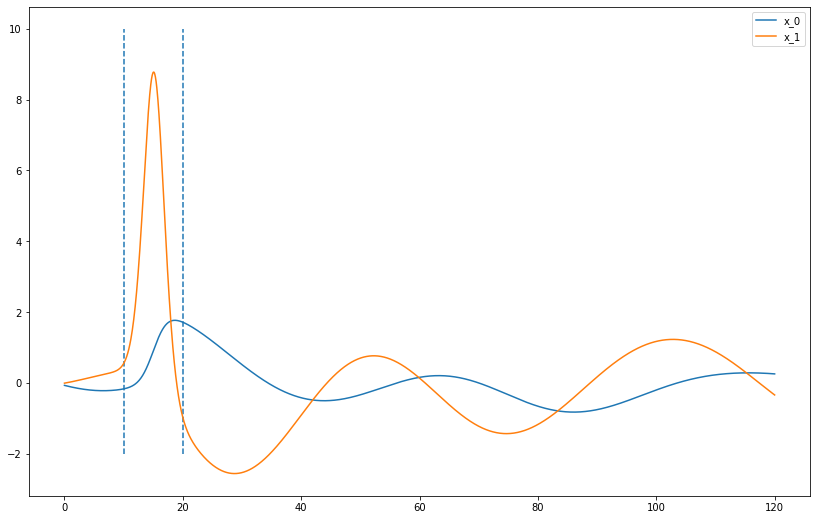

In [50]:
plt.figure(figsize=(14,9))
plt.plot(time,x_global[0],label='x_0')
plt.plot(time,x_global[1],label='x_1')
plt.vlines(10,-2,10,linestyles='--')
plt.vlines(20,-2,10,linestyles='--')
plt.legend()

Compute the same quantity with zero THz pulse

In [192]:
uprime_zf = np.zeros([3,ntimes,len(k_selected)])

for ind,k in enumerate(k_selected):
    u0 = u_ref0[:,k]
    if k == 16:
        d = 0
    else:
        d = delta[k]
    Omega0_abs = TLS.pulseParametersFromIntensity(1,intensity,fwhm=fwhm,THz_pulse=True,verbose=False)['Omega0_abs']
    Omega = lambda t : 0
    uprime_zf[:,:,ind] = TLS.solveBlochEq(u0,time,Omega,mu12=1,delta=d)

u_zf = np.zeros([3,ntimes,len(k_selected)])
for k in range(len(k_selected)):
    u_zf[:,:,k] = TLS.convertToRotatingFrame(omega,time,uprime_zf[:,:,k],invert=True)

Rsz10 = spin_dipole[k_selected,1,0].real
Isz10 = spin_dipole[k_selected,1,0].imag
sz00 = spin_dipole[k_selected,0,0].real
Sz_k_tls_zf = (u_zf[0]*Rsz10+u_zf[1]*Isz10+u_zf[2]*sz00)*trace_ref0[k_selected]
Sz_tls_zf = np.mean(Sz_k_tls_zf,axis=1).real
carriers = np.mean(trace_ref0[k_selected],axis=0).real
Pz_tls_zf = np.true_divide(Sz_tls_zf,carriers,where=carriers != 0)

In [193]:
k_selected[0:20]

array([ 3,  6, 14, 16, 19, 20, 27, 28, 31, 34, 37, 38, 41, 44, 48, 52, 54,
       61, 63, 65])

delta -0.010576156032065076


(0.8, 127.0)

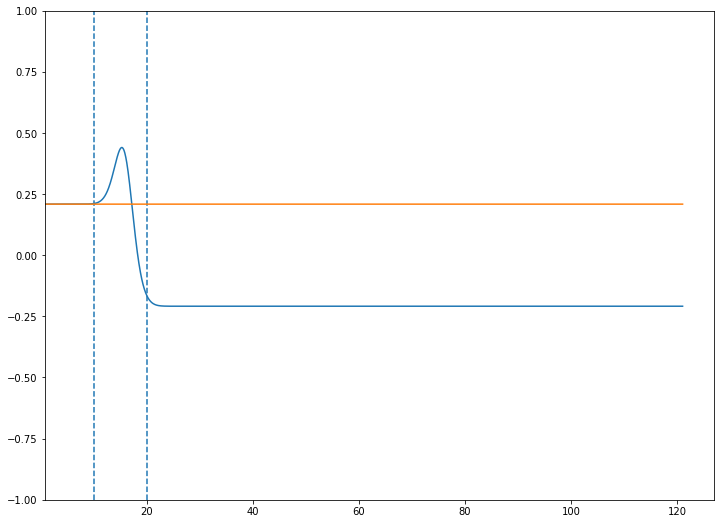

In [194]:
ind = 3
print('delta',delta[k_selected[ind]])
plt.figure(figsize=(12,9))
plt.plot(1+time,uprime[2,:,ind])
plt.plot(1+time,uprime_zf[2,:,ind])
plt.vlines(10,-1,1,linestyles='--')
plt.vlines(20,-1,1,linestyles='--')
plt.ylim((-1,1))
plt.xlim(0.80)

In [195]:
ind_t0 = np.where(time<9)[0][-1]
ind_tf = np.where(time>19)[0][0]
time[ind_t0],time[ind_tf]

(8.94447223611806, 19.02951475737869)

In [196]:
diffe = []
delta_selected = delta[k_selected]
for ind in range(len(k_selected)):
    diffe.append(uprime[2,ind_t0,ind]+uprime[2,ind_tf,ind])
diffe = np.array(diffe)

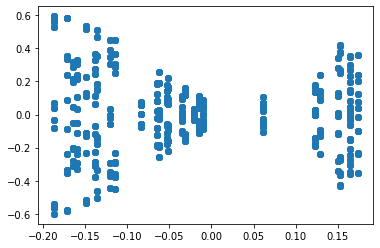

In [197]:
plt.scatter(delta_selected,diffe)

In [151]:
pulse = G.gaussianPulse(time,energy=energy,amplitude=Omega0_abs,fwhm=fwhm,verbose=False,t_start=T_delay)

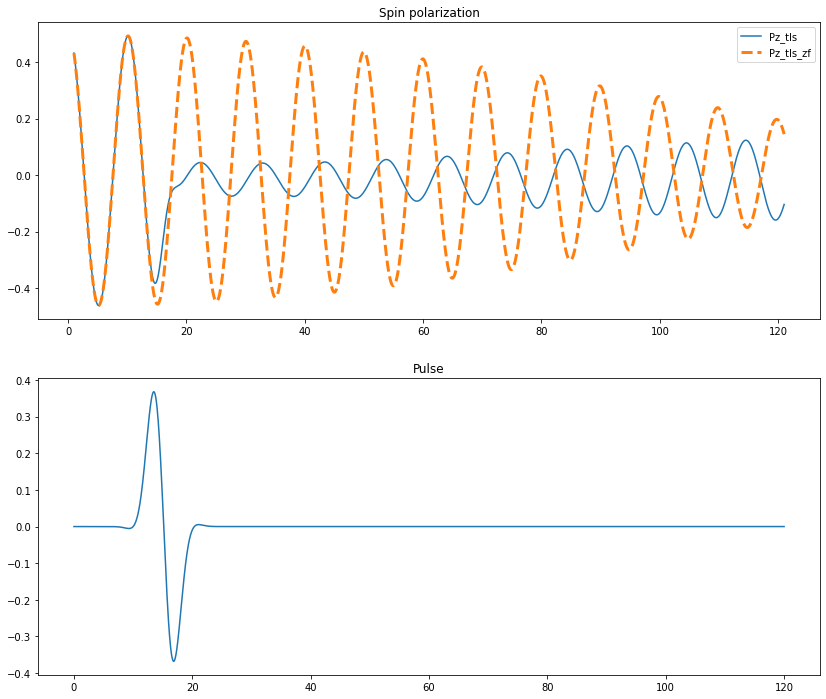

In [152]:
fig,ax= plt.subplots(2,figsize=(14,12))
ax[0].plot(1+time,Pz_tls,label='Pz_tls')
ax[0].plot(1+time,Pz_tls_zf,label='Pz_tls_zf',linestyle='--',linewidth=3)
ax[0].title.set_text('Spin polarization')
ax[1].plot(time,pulse)
ax[1].title.set_text('Pulse')
ax[0].legend()

In [ ]:
############################################################

In [84]:
fwhm_THz = 3 # ps 
NETime = 120 # ps
ntimes = 2000 # as in the rt simulations (for the green function)
time = np.linspace(0,NETime,ntimes) # in ps
T_delay = 10

h_red = C.Planck_reduced_ev_ps*1e3 # hbar in meV*ps

We start the TLS analysis using the _initial conditions_ given in

In [85]:
ref_rundir = 'SPIN_ECHO/RT_singlek_high-freq/FixSymm/'
ref_outpath = 'SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/'

In [86]:
ref_results = P.YamboParser.from_path(ref_rundir,ref_outpath)
green = ref_results.RTGreen
dm = green.buildDensityMatrix(first_band=2)
u_ref = P.buildBlochVectors(dm)
ind0 = 200 # corresponds to 1 ps 
u_ref0 = u_ref[:,ind0,:]
trace_ref = np.trace(dm[ind0],axis1=1,axis2=2).real
spin_dipole = ref_results.dipoles.spin_dipole(2,first_band=2)

Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/o-echo_THz_pi.polarization
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/o-echo_THz_pi.spin_magnetization
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/o-echo_THz_pi.current
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/o-echo_THz_pi.external_field
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/o-echo_THz_pi.orbt_magnetization
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/o-echo_THz_pi.carriers
Parse file : SPIN_ECHO/RT_singlek_high-freq/FixSymm/SAVE/ns.db1
Parse file : SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/ndb.dipoles
Parse file : SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/ndb.RT_G_PAR


period of the pulse oscillation 4.5951863302581355


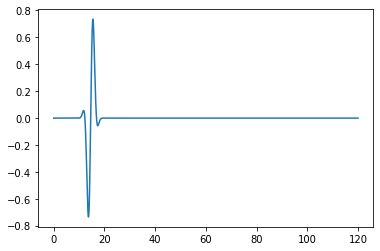

In [87]:
energy = 0.9
omega = energy/h_red # angular frequency of the pulse
print('period of the pulse oscillation',2*np.pi/omega) 
pulse= G.gaussianPulse(time,energy=energy,amplitude=1,fwhm=fwhm_THz,envelope_only=False,verbose=False,t_start=T_delay)
plt.plot(time,pulse)

In [88]:
import random as rand
numk = 1000
delta_range = 0.8 # meV
de = [0.] # the first kpoint has zero detuning
for i in range(numk-1):
    de.append(delta_range*(rand.random()-0.5))
de_ccp = energy+np.array(de)
numk = len(de_ccp)
mu12 = np.array([1 for ind in range(numk)]) # all the dipoles are equal to 1

In [89]:
energies,pulse_ft = G.evalPulseFourierTransform(time,pulse,THz_pulse=True)

time unit: ps - energy unit: meV
energy resolution of the FT: 0.03444666551793332 meV
maximum energy: 34.412218852415386 meV
FWHM of the FT of the pulse: 1.1367399620917997 meV


(0.0, 3.0)

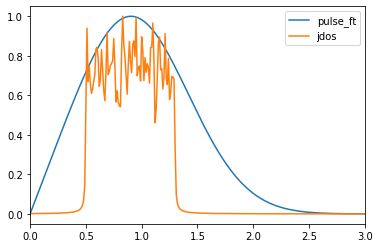

In [90]:
jdos = U.Dos()
jdos.append(de_ccp,minVal=0,maxVal=3,eta=5e-3,label='jdos')
plt.plot(energies,pulse_ft/max(pulse_ft),label='pulse_ft')
jdos.plot(plt,rescale=True)
plt.xlim(0,3)

In [55]:
1.5/h_red-(1.5-0.4)/h_red

0.6077069791061238

In [91]:
k_ref = 0
u0 = u_ref0[:,k_ref]
sz = spin_dipole[k_ref]
t0 = trace_ref[k_ref]
Rsz10 = sz[1,0].real
Isz10 = sz[1,0].imag
sz00 = sz[0,0].real
theta = np.pi
pars = TLS.pulseParametersFromTheta(mu12[k_ref],theta,fwhm=fwhm_THz,THz_pulse=True)
intensity = pars['intensity']
intensity,u0

time unit: ps
the width parameter of the pulse is 1.2739827004320285 ps
Rabi coupling (ps^-1): 0.9837764177570706
Rabi coupling (module) (ps^-1): 0.9837764177570706
field amplitude (V/m): 12236608.09993951
field intensity (kW/cm^2) : 39745.82682214511


(39745.82682214511, array([ 0.05624854, -0.96059003, -0.02491248]))

In [92]:
uprime = np.zeros([3,ntimes,numk])

for k in range(numk):
    omega0= de_ccp[k]/h_red
    delta = omega - omega0
    pars = TLS.pulseParametersFromIntensity(mu12[k],intensity,fwhm=fwhm_THz,THz_pulse=True,verbose=False)
    Omega = lambda t : G.gaussianPulse(t,energy=energy,amplitude=pars['Omega0_abs'],fwhm=fwhm_THz,\
                    envelope_only=True,verbose=False,t_start=T_delay)
    uprime[:,:,k] = TLS.solveBlochEq(u0,time,Omega,mu12=mu12[k],delta=delta)

u = np.zeros([3,ntimes,numk])
for k in range(numk):
    u[:,:,k] = TLS.convertToRotatingFrame(omega,time,uprime[:,:,k],invert=True)

Sz_k_tls = (u[0]*Rsz10+u[1]*Isz10+u[2]*sz00)*t0
Sz_tls = np.mean(Sz_k_tls,axis=1)
carriers = t0
Pz_tls = np.true_divide(Sz_tls,carriers,where=carriers != 0)

The same with zero field

In [93]:
uprime_zf = np.zeros([3,ntimes,numk])

for k in range(numk):
    omega0= de_ccp[k]/h_red
    delta = omega - omega0
    Omega = lambda t : 0
    uprime_zf[:,:,k] = TLS.solveBlochEq(u0,time,Omega,mu12=mu12[k],delta=delta)

u_zf = np.zeros([3,ntimes,numk])
for k in range(numk):
    u_zf[:,:,k] = TLS.convertToRotatingFrame(omega,time,uprime_zf[:,:,k],invert=True)

Sz_k_tls_zf = (u_zf[0]*Rsz10+u_zf[1]*Isz10+u_zf[2]*sz00)*t0
Sz_tls_zf = np.mean(Sz_k_tls_zf,axis=1)
carriers = t0
Pz_tls_zf = np.true_divide(Sz_tls_zf,carriers,where=carriers != 0)

We plot the component of the $x$ vector in the rotating frame

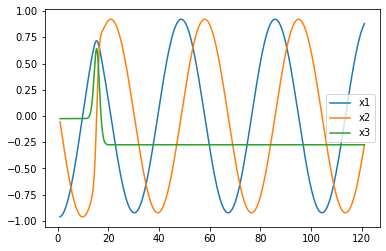

In [94]:
k = 2
x = TLS.convertToXbasis(uprime[:,:,k],mu12=mu12[k])
plt.plot(1+time,x[0],label='x1')
plt.plot(1+time,x[1],label='x2')
plt.plot(1+time,x[2],label='x3')
plt.legend()

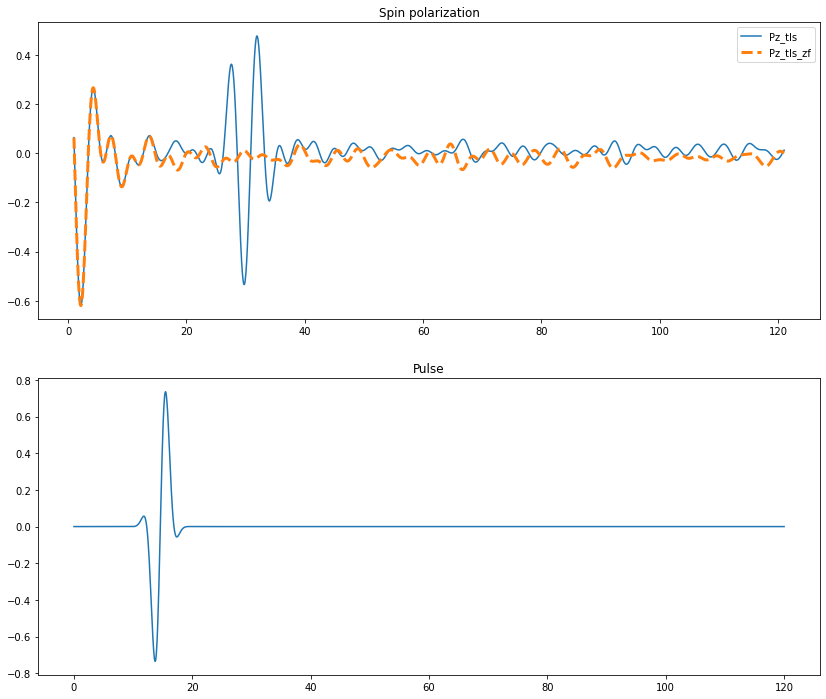

In [95]:
fig,ax= plt.subplots(2,figsize=(14,12))
ax[0].plot(1+time,Pz_tls,label='Pz_tls')
ax[0].plot(1+time,Pz_tls_zf,label='Pz_tls_zf',linestyle='--',linewidth=3)
ax[0].title.set_text('Spin polarization')
ax[1].plot(time,pulse)
ax[1].title.set_text('Pulse')
ax[0].legend()

### Solution of the Bloch equations with the THz pulse. Analysis of the echo mechanism

In [223]:
from mppi import Utilities as U

We use the TLS to discuss the possibility of a revival of the spin polarization using a properly chosen echo pulse.

We choose a reference yambo computation used to read the dipoles, the (k dependent) values of the energy gap of the conduction
states and the _initial conditions_ for the Bloch vector. The TLS analysis starts at t=1 ps.

In [224]:
ref_rundir = 'SPIN_ECHO/RT_k100_random/FixSymm/'
ref_outpath = 'SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory'

In [225]:
ref_results = P.YamboParser.from_path(ref_rundir,ref_outpath)

Parse file SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory/o-k100_random_boost_Ghistory.spin_magnetization
Parse file SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory/o-k100_random_boost_Ghistory.external_field
Parse file SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory/o-k100_random_boost_Ghistory.orbt_magnetization
Parse file SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory/o-k100_random_boost_Ghistory.polarization
Parse file SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory/o-k100_random_boost_Ghistory.carriers
Parse file SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory/o-k100_random_boost_Ghistory.current
Parse file : SPIN_ECHO/RT_k100_random/FixSymm/SAVE/ns.db1
Parse file : SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory/ndb.dipoles
Parse file : SPIN_ECHO/RT_k100_random/FixSymm/k100_random_boost_Ghistory/ndb.RT_G_PAR


In [226]:
#ref_results.get_info()

In [227]:
# We extract the relevant quantities from the yambo computation

#time_output = 1e-3*ref_results.data['external_field']['time']
#Pz_output = ref_results.data['spin_magnetization']['Mc_z']

x_dipole = ref_results.dipoles.r_dipole(0,first_band=4)
de_ccp_k = 1e3*ref_results.dft.get_transitions(initial=[8,9],final=[8,9])[:,0] # in meV
dm = ref_results.RTGreen.buildDensityMatrix(first_band=4)
trace_cc = np.trace(dm,axis1=2,axis2=3) #trace in the conduction sector
u_ref = P.buildBlochVectors(dm)

spin_dipole = ref_results.dipoles.spin_dipole(2,first_band=4)

We choose t=1 ps as the time value at which the initial condition is set.

In [228]:
comp,ntimes_ref,numk = u_ref.shape
ntimes_ref,numk

(403, 4753)

In [229]:
NETime_ref = 10 # the length of the yambo simulation in ps 
time_ref = np.linspace(0,NETime_ref,ntimes_ref) # in ps

We extract the _initial conditions_ of the TLS analysis from the RT density matrix. Note that, apart from the Bloch vector we also need
the values of the k dependent trace of the $\rho_{cc'}$

In [230]:
ind0 = np.where(time_ref<=1)[0][-1] 
print('t0 =',time_ref[ind0])
u_ref0 = u_ref[:,ind0,:]
trace_ref = trace_cc[ind0] #np.trace(dm[ind0],axis1=1,axis2=2).real

t0 = 0.9950248756218906


We try to indiviudate the k points that are relevant for the dynamics. 

We use the trace of the density matrix as the relevance criterion and we compare the expectation values of the 
carriers and of the degree of the spin polarization

In [231]:
k_activated = np.where(trace_ref > 1e-3)[0]
k_activated.shape

(3536,)

In [232]:
carriers = np.mean(trace_cc,axis=1).real # average over k
carriers_activated = np.mean(trace_cc[:,k_activated],axis=1).real

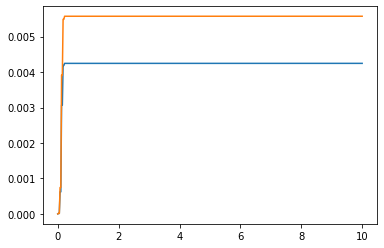

In [233]:
plt.plot(time_ref,carriers)
plt.plot(time_ref,carriers_activated)

In [234]:
Sz_ref = np.mean(np.trace(np.matmul(dm,spin_dipole),axis1=2,axis2=3),axis=1).real
Pz_ref = np.true_divide(Sz_ref,carriers.real,where=carriers.real!=0)

In [235]:
Sz_ref_activated = np.mean(np.trace(np.matmul(dm[:,k_activated,:,:],spin_dipole[k_activated,:,:]),axis1=2,axis2=3),axis=1).real
Pz_ref_activated = np.true_divide(Sz_ref_activated,carriers_activated.real,where=carriers_activated.real!=0)

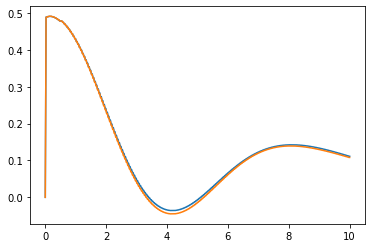

In [236]:
plt.plot(time_ref,Pz_ref)
plt.plot(time_ref,Pz_ref_activated)

We compute the jdos of the cc' transition restricted to this set of kpoints

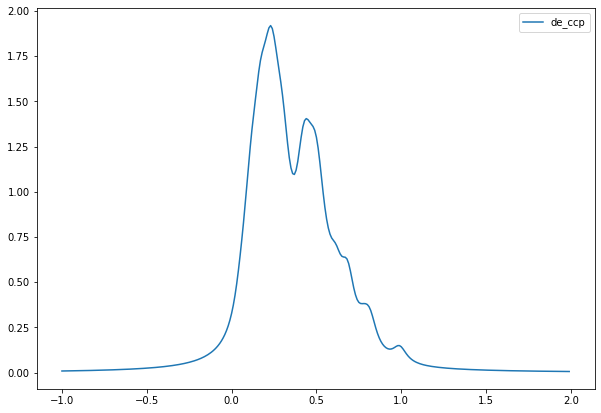

In [237]:
jdos = U.Dos()
plt.figure(figsize=(10,7))
jdos.append(de_ccp_k[k_activated],minVal=-1,maxVal=2,label='de_ccp')
jdos.plot(plt)

We define the parameters of the THz pulse. We want that the pulse is able to couple with all the kpoints that contribute
the S_z. In this way we can try to invert to Bloch vector of all the k points to realize the spin echo

In [247]:
THz_fwhm =  4 #ps
energy = 0.3 # energy of the Thz pump in meV
h_red = C.Planck_reduced_ev_ps*1e3 # hbar in meV*ps
omega = energy/h_red # angular frequency of the pulse

In [248]:
NETime_Ft = 200 # in ps (used only to compute the FT)
ntimes_Ft = 10000
time_Ft = np.linspace(0,NETime_Ft,ntimes_Ft) #
T_delay = 1

In [249]:
pulse = G.gaussianPulse(time_Ft,energy=energy,amplitude=1,fwhm=THz_fwhm,THz_pulse=True,t_start=T_delay,envelope_only=False)

time unit: ps - energy unit: meV
period of the oscillations 13.785558990774406 ps
width of the pulse 1.6986436005760381 ps
fwhm of the pulse 4 ps


(0.0, 50.0)

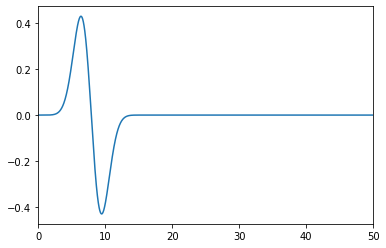

In [250]:
plt.plot(time_Ft,pulse)
plt.xlim(0,50)

In [251]:
energies,pulse_ft = G.evalPulseFourierTransform(time_Ft,pulse,THz_pulse=True)

time unit: ps - energy unit: meV
energy resolution of the FT: 0.020676270646151997 meV
maximum energy: 103.36067696011384 meV
FWHM of the FT of the pulse: 0.6616406606768639 meV


(-1.0, 2.0)

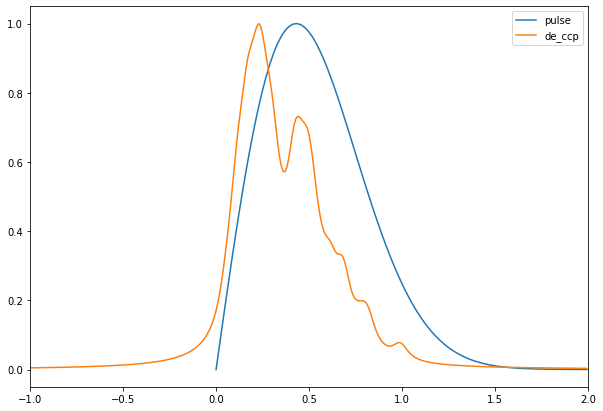

In [252]:
plt.figure(figsize=(10,7))
plt.plot(energies,pulse_ft/max(pulse_ft),label='pulse')
jdos.plot(plt,rescale=True)
plt.xlim(-1,2)
#plt.legend()

A pulse with these features overlap with the JDos of the cc' transitions. But due to its shape is the RWA justified?

In [ ]:
#####################################################à

In [253]:
THz_fwhm =  4 #ps
energy = 0.3 # energy of the Thz pump in meV
h_red = C.Planck_reduced_ev_ps*1e3 # hbar in meV*ps
omega = energy/h_red # angular frequency of the pulse

In [254]:
NETime_Ft = 200 # in ps (used only to compute the FT)
ntimes_Ft = 10000
time_Ft = np.linspace(0,NETime_Ft,ntimes_Ft) #
T_delay = 1

In [255]:
pulse = G.gaussianPulse(time_Ft,energy=energy,amplitude=1,fwhm=THz_fwhm,THz_pulse=True,t_start=T_delay,envelope_only=False)

time unit: ps - energy unit: meV
period of the oscillations 13.785558990774406 ps
width of the pulse 1.6986436005760381 ps
fwhm of the pulse 4 ps


In [256]:
energies,pulse_ft = G.evalPulseFourierTransform(time_Ft,pulse,THz_pulse=True)

time unit: ps - energy unit: meV
energy resolution of the FT: 0.020676270646151997 meV
maximum energy: 103.36067696011384 meV
FWHM of the FT of the pulse: 0.6616406606768639 meV


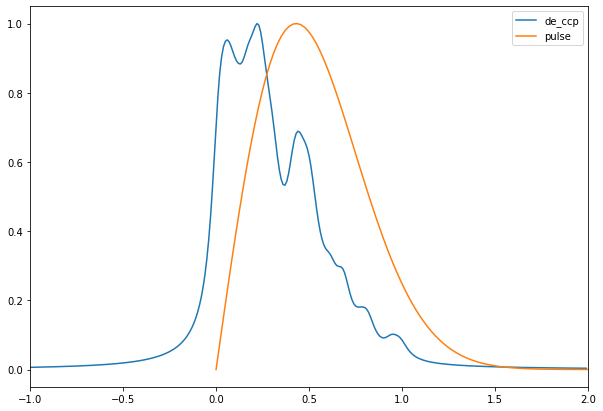

In [257]:
jdos = U.Dos()
plt.figure(figsize=(10,7))
jdos.append(de_ccp_k,minVal=-1,maxVal=2,label='de_ccp')
jdos.plot(plt,rescale=True)
plt.plot(energies,pulse_ft/max(pulse_ft),label='pulse')
plt.xlim(-1,2)
plt.legend()

We analyze the distribution of the dipoles transitions elements $\mu_{12}$

In [258]:
mu12 = abs(x_dipole[:,0,1])

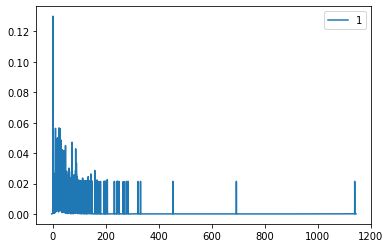

In [259]:
mu_dos = U.Dos()
mu_dos.append(mu12)
mu_dos.plot(plt)

In [260]:
k_decrease_energy = np.argsort(de_ccp_k)[::-1]

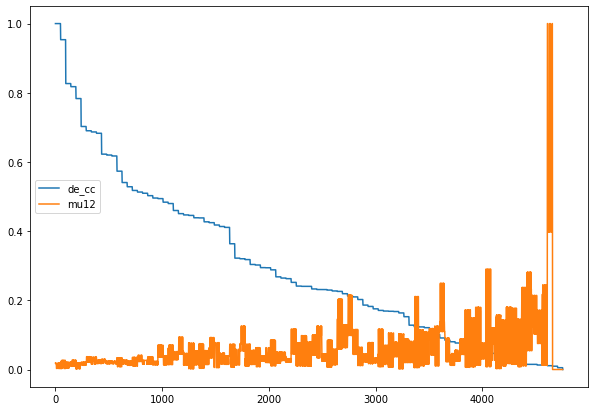

In [261]:
plt.figure(figsize=(10,7))
plt.plot(de_ccp_k[k_decrease_energy]/max(de_ccp_k),label='de_cc')
plt.plot(mu12[k_decrease_energy]/max(mu12),label='mu12')
plt.legend()

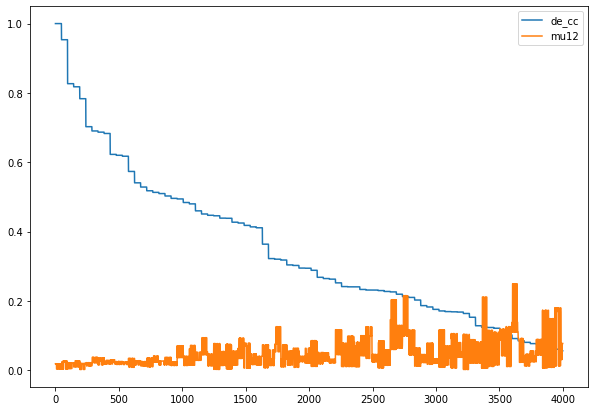

In [262]:
k_decrease_energy_cut = k_decrease_energy[:4000]
plt.figure(figsize=(10,7))
plt.plot(de_ccp_k[k_decrease_energy_cut]/max(de_ccp_k),label='de_cc')
plt.plot(mu12[k_decrease_energy_cut]/max(mu12),label='mu12')
plt.legend()

We use only the k points in the k_decrease_energy_cut array and use the k point
with the highest frequency as the reference to set the $\pi$ amplitude of the pulse

In [263]:
k_ref = 1
mu12_ref = -x_dipole[k_ref,0,1]
print(abs(mu12_ref))
theta = np.pi
pars = TLS.pulseParametersFromTheta(mu12_ref,np.pi,fwhm=THz_fwhm,THz_pulse=True)
pars

27.52873753271095
time unit: ps
the width parameter of the pulse is 1.6986436005760381 ps
Rabi coupling (ps^-1): (0.18259027824106627+0.7148827266536455j)
Rabi coupling (module) (ps^-1): 0.7378323133178032
field amplitude (V/m): 333377.29578225466
field intensity (kW/cm^2) : 29.50132163723414


{'Omega0': (0.18259027824106627+0.7148827266536455j),
 'Omega0_abs': 0.7378323133178032,
 'field_amplitude': 333377.29578225466,
 'intensity': 29.50132163723414}

In [264]:
amplitude = pars['field_amplitude']
Omega0_abs = pars['Omega0_abs']
intensity = pars['intensity']

We choose t=1 ps as the time value at which the initial condition is set.

In [265]:
comp,ntimes_ref,numk = u_ref.shape
ntimes_ref,numk

(403, 4753)

In [266]:
NETime_ref = 10 # the length of the yambo simulation in ps 
time_ref = np.linspace(0,NETime_ref,ntimes_ref) # in ps

We extract the _initial conditions_ of the TLS analysis from the RT density matrix. Note that, apart from the Bloch vector we also need
the values of the k dependent trace of the $\rho_{cc'}$

In [267]:
ind0 = np.where(time_ref<=1)[0][-1] 
print('t0 =',time_ref[ind0])
u_ref0 = u_ref[:,ind0,:]
trace_ref = np.trace(dm[ind0],axis1=1,axis2=2).real

t0 = 0.9950248756218906


In [268]:
NETime = 120 # length of the TLS analysis in ps
ntimes= 1200
time = np.linspace(0,NETime,ntimes)

We solve the Bloch equations and compute the spin polarization

In [269]:
spin_dipole = ref_results.dipoles.spin_dipole(2,first_band=4)
Rsz10 = spin_dipole[:,1,0].real
Isz10 = spin_dipole[:,1,0].imag
sz00 = spin_dipole[:,0,0].real
spin_dipole.shape

(4753, 2, 2)

In [270]:
uprime = np.zeros([3,ntimes,numk])

for k in k_decrease_energy_cut:
    omega0= de_ccp_k[k]/h_red
    delta = omega - omega0
    uprime0 = u_ref0[:,k]
    mu12 = 1 #-x_dipole[k,0,1]
    #pars = TLS.pulseParametersFromIntensity(mu12,intensity,fwhm=THz_fwhm,THz_pulse=True,verbose=False)
    pars = TLS.pulseParametersFromTheta(mu12,np.pi,fwhm=THz_fwhm,THz_pulse=True,verbose=False)
    Omega = lambda t : G.gaussianPulse(t,energy=energy,amplitude=pars['Omega0_abs'],fwhm=THz_fwhm,envelope_only=True,verbose=False)
    uprime[:,:,k] = TLS.solveBlochEq(uprime0,time,Omega,mu12=mu12,delta=delta)

u = np.zeros([3,ntimes,numk])
for k in range(numk):
    u[:,:,k] = TLS.convertToRotatingFrame(omega,time,uprime[:,:,k],invert=True)

Sz_k_tls = (u[0]*Rsz10+u[1]*Isz10+u[2]*sz00)*trace_ref
Sz_tls = np.mean(Sz_k_tls,axis=1)
carriers = np.mean(trace_ref,axis=0)
Pz_tls = np.true_divide(Sz_tls,carriers,where=carriers != 0)

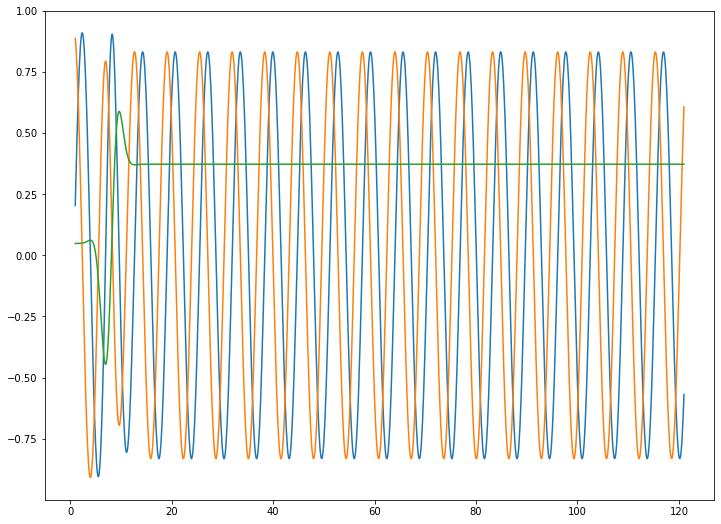

In [271]:
k=1
plt.figure(figsize=(12,9))
plt.plot(1+time,uprime[0,:,k])
plt.plot(1+time,uprime[1,:,k])
plt.plot(1+time,uprime[2,:,k])

We peform the same computation with a zero THz pulse

In [272]:
uprime_zf = np.zeros([3,ntimes,numk])
Omega = lambda t : 0

for k in k_decrease_energy_cut:
    omega0= de_ccp_k[k]/h_red
    delta = omega - omega0
    uprime0 = u_ref0[:,k]
    mu12 = -x_dipole[k,0,1]
    uprime_zf[:,:,k] = TLS.solveBlochEq(uprime0,time,Omega,mu12=mu12,delta=delta)

u_zf = np.zeros([3,ntimes,numk])
for k in range(numk):
    u_zf[:,:,k] = TLS.convertToRotatingFrame(omega,time,uprime_zf[:,:,k],invert=True)


Sz_k_tls_zf = (u_zf[0]*Rsz10+u_zf[1]*Isz10+u_zf[2]*sz00)*trace_ref
Sz_tls_zf = np.mean(Sz_k_tls_zf,axis=1)
carriers = np.mean(trace_ref,axis=0)
Pz_tls_zf = np.true_divide(Sz_tls_zf,carriers,where=carriers != 0)

We plot the spin polarization and the pulse

In [273]:
pulse = G.gaussianPulse(time,energy=energy,amplitude=amplitude,fwhm=THz_fwhm,THz_pulse=True,t_start=0,envelope_only=False)

time unit: ps - energy unit: meV
period of the oscillations 13.785558990774406 ps
width of the pulse 1.6986436005760381 ps
fwhm of the pulse 4 ps


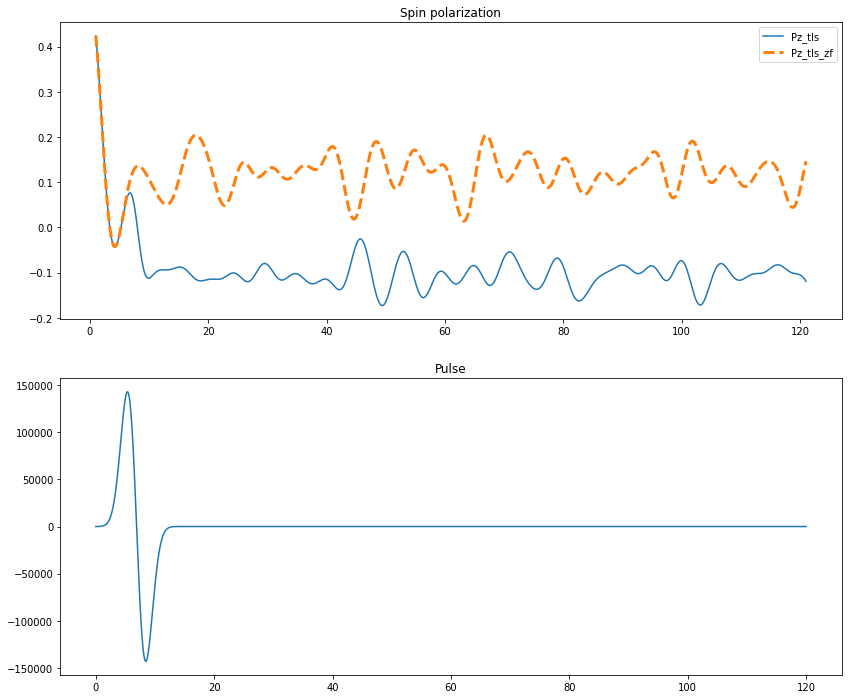

In [275]:
fig,ax= plt.subplots(2,figsize=(14,12))
ax[0].plot(1+time,Pz_tls,label='Pz_tls')
ax[0].plot(1+time,Pz_tls_zf,label='Pz_tls_zf',linestyle='--',linewidth=3)
ax[0].title.set_text('Spin polarization')
ax[1].plot(time,pulse)
ax[1].title.set_text('Pulse')
ax[0].legend()